https://mljar.com/blog/extract-rules-decision-tree/

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from scipy.special import boxcox, inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from bayes_opt import BayesianOptimization

from sklearn import metrics

import shap

### Dictionaries

In [74]:
ed_dict = {1:'Below college',
           2:'College',
           3:'Bachelor',
           4:'Master',
           5:'Doctor'}
env_sat_dict = {1:'Low',
                2:'Medium',
                3:'High',
                4:'Very high'}
prat_dict = {1:'Low',
             2:'Good',
             3:'Excellent',
             4:'Outstanding'}
wlivb_dict = {1:'Bad',
             2:'Good',
             3:'Better',
             4:'Best'}



### Functions

In [75]:
################
### Features ###
################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [76]:
def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [77]:
def new_f(new_name, name, var, cvar):
    X_train[new_name] = 0
    X_train.loc[X_train[cvar] == name, new_name] = X_train[var]
    X_test[new_name] = 0
    X_test.loc[X_test[cvar] == name, new_name] = X_test[var]

In [78]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [79]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [80]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [81]:
#######################
### Model selection ###
#######################

def select_model(X, y, pipeline=None):
    """Test a range of classifiers and return their performance metrics on training data.

    Args:
        X (object): Pandas dataframe containing X_train data.
        y (object): Pandas dataframe containing y_train data.
        pipeline (object): Pipeline from get_pipeline().

    Return:
        df (object): Pandas dataframe containing model performance data.
    """

    classifiers = {}
    classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False,
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                      )})
    classifiers.update({"LGBMClassifier": LGBMClassifier()})
    classifiers.update({"RandomForestClassifier": RandomForestClassifier(n_estimators=1000, max_depth=3, n_jobs=5)})
    classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})
    classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    classifiers.update({"ExtraTreesClassifier": ExtraTreeClassifier()})
    classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})
    classifiers.update({"KNeighborsClassifier": KNeighborsClassifier()})
    classifiers.update({"RidgeClassifier": RidgeClassifier()})
    classifiers.update({"SGDClassifier": SGDClassifier()})
    classifiers.update({"BernoulliNB": BernoulliNB()})
    classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})

    # Stacking
    models = []

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))

    # classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('LGBMClassifier', LGBMClassifier()))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    # classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('RandomForestClassifier', RandomForestClassifier()))
    # models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    # models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})

    #scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

    df_models = pd.DataFrame(columns=['model', 'run_time', 'accuracy'])

    for key in tqdm(classifiers):
        start_time = time.time()
        pipeline = get_pipeline(X, classifiers[key])
        cv = cross_val_score(pipeline, X, y, cv=10, scoring = 'roc_auc')
        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'accuracy': cv.mean(),
        }
        row_df = pd.DataFrame(row, index=[0])

        df_models = pd.concat([df_models,
                                   row_df],
                                  axis=0,
                                  ignore_index=True)

        df_models = df_models.sort_values(by='accuracy', ascending=False)
    return df_models

####################################
### Pipeline for Baseline models ###
####################################

def get_pipeline(X, model):
    """
    Return a pipeline to preprocess data and bundle with a model.

    Args:
        X (object): X_train data.
        model (object): scikit-learn model object, i.e. XGBClassifier

    Returns:
        Pipeline (object): Pipeline steps.
    """

    numeric_columns = list(X.select_dtypes(exclude=['object']).columns.values.tolist())
    categorical_columns = list(X.select_dtypes(include=['object']).columns.values.tolist())
    numeric_pipeline = SimpleImputer(strategy='constant')
    categorical_pipeline = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_pipeline, numeric_columns),
            ('categorical', categorical_pipeline, categorical_columns),
            ], remainder='passthrough'
    )

    bundled_pipeline = imbpipeline(steps=[
        #('preprocessor', preprocessor),
        #('smote', SMOTE(random_state=1)),
        #('scaler', MaxAbsScaler()),
        ('model', model)
    ])

    return bundled_pipeline

In [82]:
######################################
### Catboost Hyperparameter tuning ###
######################################

def CB_opt(n_estimators, depth, learning_rate, max_bin,
    subsample, num_leaves, l2_leaf_reg, model_size_reg):
    catb_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
    for train_index, test_index in skf.split(X_train_mod, y_train):

      trainx, valx = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
      trainy, valy = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

      reg = CatBoostClassifier(verbose = 0,
                               n_estimators = int(n_estimators),
                               learning_rate = learning_rate,
                               subsample = subsample,
                               l2_leaf_reg = l2_leaf_reg,
                               max_depth = int(depth),
                               num_leaves = int(num_leaves),
                               random_state = 88,
                               grow_policy = "Lossguide",
                               max_bin = int(max_bin),
                               use_best_model = True,
                               model_size_reg = model_size_reg,
                               eval_metric = 'AUC'

                               )

      reg.fit(trainx, trainy, eval_set = (valx, valy))
      catb_scores.append(roc_auc_score(valy, reg.predict(valx)))
    return np.mean(catb_scores)

In [83]:
#################
### XGB Boost ###
#################

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma):

    estimator_function = xgb.XGBClassifier(max_depth = int(max_depth),
                                               learning_rate = learning_rate,
                                               n_estimators = int(n_estimators),
                                               reg_alpha = reg_alpha,
                                               gamma = gamma,
                                               reg_lambda = reg_lambda,
                                               nthread = -1,
                                               objective = "binary:logistic",
                                               eval_metric = "auc",
                                               seed = seed)
    # Fit the estimator
    estimator_function.fit(X_train_mod, y_train)

    # calculate out-of-the-box roc_score using validation set 1
    probs = estimator_function.predict_proba(X_train_mod)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_train,probs)

    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(X_test)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_test,probs)

    # return the mean validation score to be maximized
    return np.array([val1_roc,val2_roc]).mean()

In [84]:
##################
### LGBM model ###
##################

def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):

    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    cv_result = lgb.cv(params,
                           train_data,
                           nfold = 10,
                           seed = 6,
                           stratified = True,
                           verbose_eval = 200,
                           metrics = ['auc'])
    return max(cv_result['auc-mean'])

In [85]:
########################
### Confusion matrix ###
########################

def cm2df(cm, labels):
            df = pd.DataFrame()

            for i, row_label in enumerate(labels):
                rowdata={}
        
                for j, col_label in enumerate(labels): 
                    rowdata[col_label]=cm[i,j]
                df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
            return df[labels]

## Read in the data

In [86]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(data.shape)
data.head()

(1470, 35)


Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [87]:
print(list(data.columns))

['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [88]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])

Column:  Age , number of unique classes:  43
Values:  [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Column:  Attrition , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  BusinessTravel , number of unique classes:  3
Values:  ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
Column:  DailyRate , number of unique classes:  886
Column:  Department , number of unique classes:  3
Values:  ['Human Resources', 'Research & Development', 'Sales']
Column:  DistanceFromHome , number of unique classes:  29
Values:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Column:  Education , number of unique classes:  5
Values:  [1, 2, 3, 4, 5]
Column:  EducationField , number of unique classes:  6
Values:  ['Medical', 'Other', 'Marketing', 'Human Resources', 'Life Sciences', 'Technical Degree']
Column:  Emp

In [89]:
nonvar_lst

['EmployeeCount', 'Over18', 'StandardHours']

## Missing data

In [90]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

Count  perc
Age                           0   0.0
Attrition                     0   0.0
BusinessTravel                0   0.0
DailyRate                     0   0.0
Department                    0   0.0
DistanceFromHome              0   0.0
Education                     0   0.0
EducationField                0   0.0
EmployeeCount                 0   0.0
EmployeeNumber                0   0.0
EnvironmentSatisfaction       0   0.0
Gender                        0   0.0
HourlyRate                    0   0.0
JobInvolvement                0   0.0
JobLevel                      0   0.0
JobRole                       0   0.0
JobSatisfaction               0   0.0
MaritalStatus                 0   0.0
MonthlyIncome                 0   0.0
MonthlyRate                   0   0.0
NumCompaniesWorked            0   0.0
Over18                        0   0.0
OverTime                      0   0.0
PercentSalaryHike             0   0.0
PerformanceRating             0   0.0
RelationshipSatisfaction      0   0.0
StandardHours                 0   0.0
StockOptionLevel              0   0.0
TotalWorkingYears             0   0.0
TrainingTimesLastYear         0   0.0
WorkLifeBalance               0   0.0
YearsAtCompany                0   0.0
YearsInCurrentRole            0   0.0
YearsSinceLastPromotion       0   0.0
YearsWithCurrManager          0   0.0

## Target variable

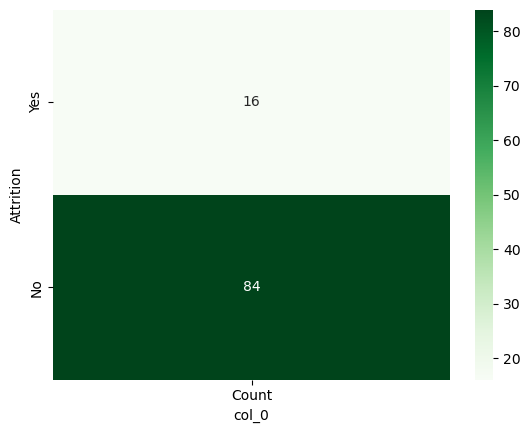

In [91]:

room_t = pd.DataFrame(pd.crosstab(data.Attrition, columns = 'Count', normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

## Adjust the training set

In [92]:
data.Department = data.Department.str.replace(' ','_')
data.Department = data.Department.str.replace('&','')

data['Education'] = data['Education'].map(ed_dict)
data['EnvironmentSatisfaction'] = data['EnvironmentSatisfaction'].map(env_sat_dict)
data['JobInvolvement'] = data['JobInvolvement'].map(env_sat_dict)
data['JobSatisfaction'] = data['JobSatisfaction'].map(env_sat_dict)
data['RelationshipSatisfaction'] = data['RelationshipSatisfaction'].map(env_sat_dict)
data['PerformanceRating'] = data['PerformanceRating'].map(prat_dict)
data['WorkLifeBalance'] = data['WorkLifeBalance'].map(wlivb_dict)

data['Attrition_n'] = (data.Attrition == 'Yes').astype(int)

data = data.drop(nonvar_lst + ['EmployeeNumber'], axis = 1)
data.JobLevel = data.JobLevel.astype(str)
data.StockOptionLevel = data.StockOptionLevel.astype(str)


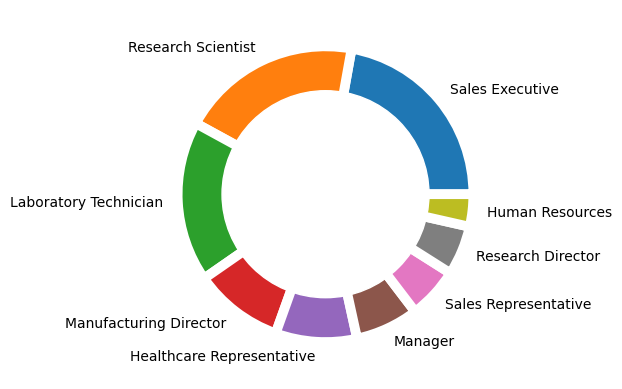

In [93]:
c_loc = data.sort_values(by = 'JobRole')
c_loc = c_loc.groupby(['JobRole'])['Age'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['Age']/data.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum() 
c_loc = c_loc.reset_index(drop=True)

my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(c_loc.perc, labels=c_loc.JobRole, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

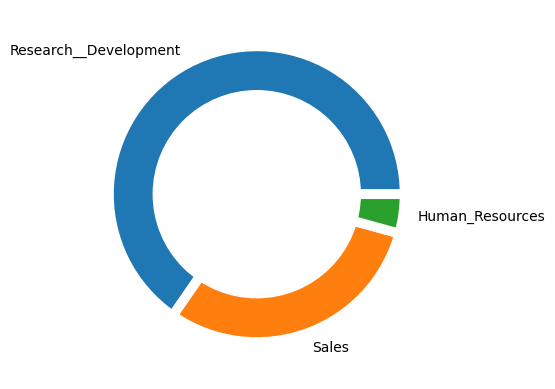

In [94]:
name = 'Department'
c_loc = data.sort_values(by = name)
c_loc = c_loc.groupby([name])['Age'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['Age']/data.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum() 
c_loc = c_loc.reset_index(drop=True)

my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Numerical data

In [95]:
num_cols = list(data.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
#num_cols.remove('y_n')
num_cols.remove('Attrition_n')
print(num_cols)

['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [96]:
# [18. 29. 33. 38. 45. 60.]

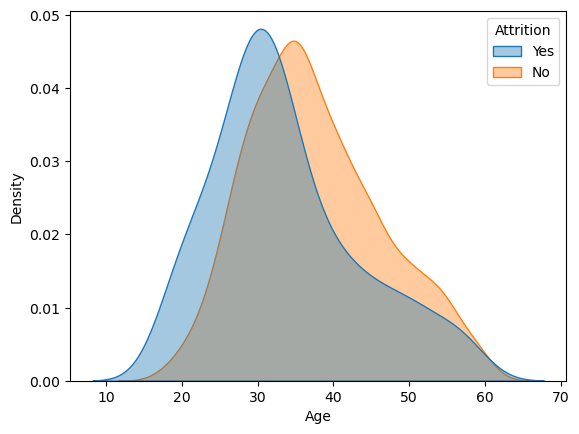

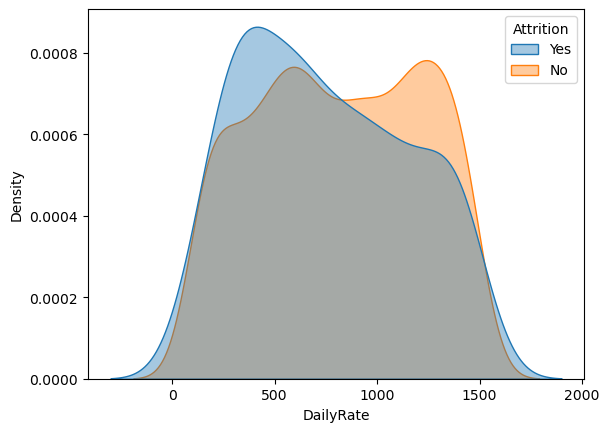

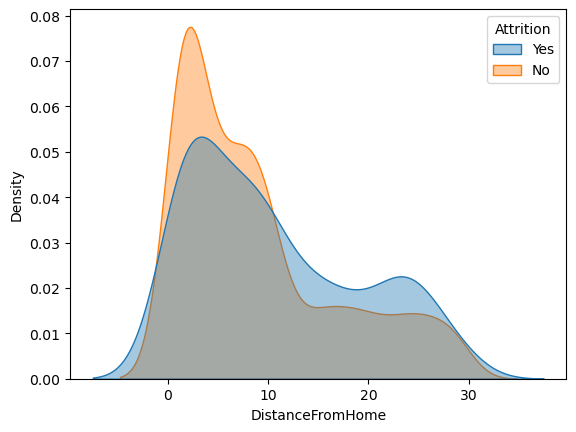

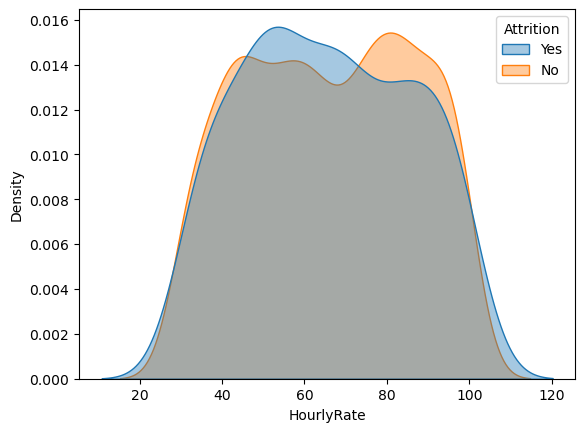

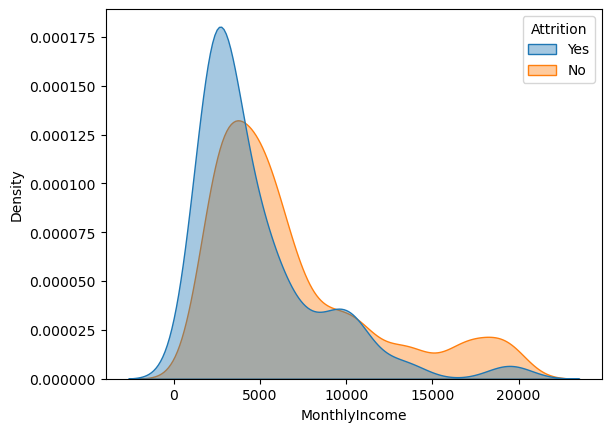

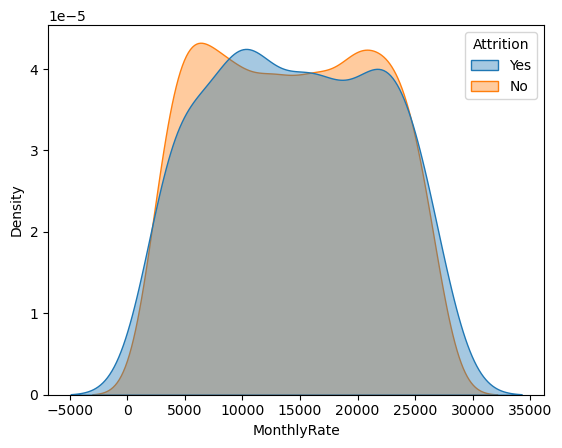

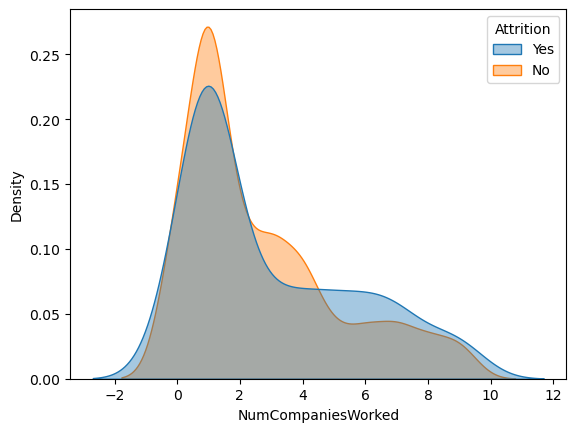

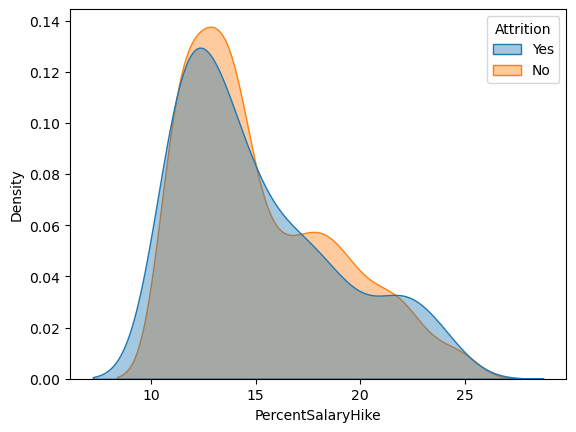

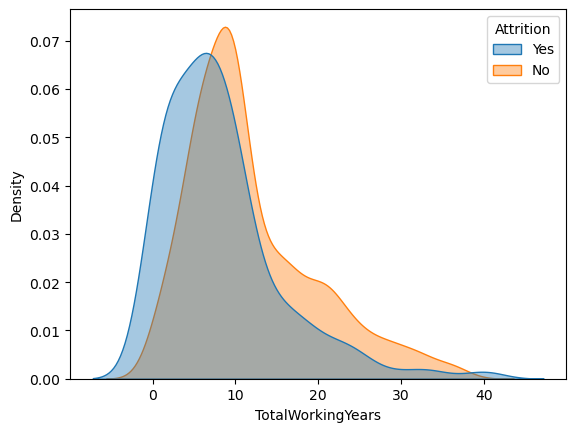

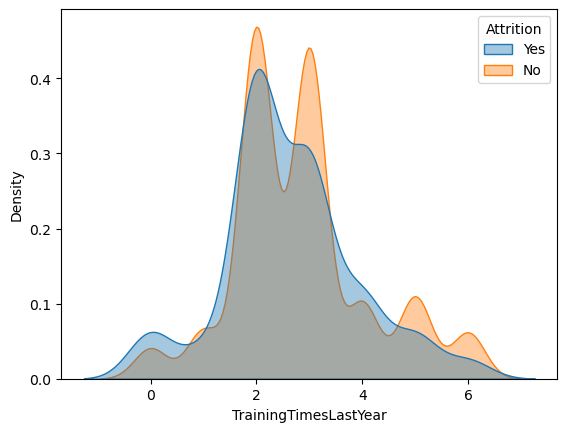

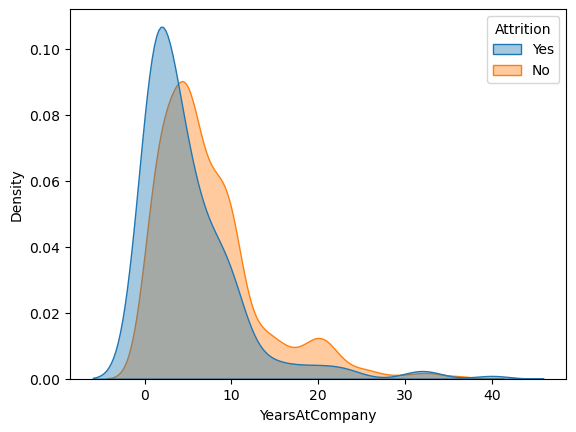

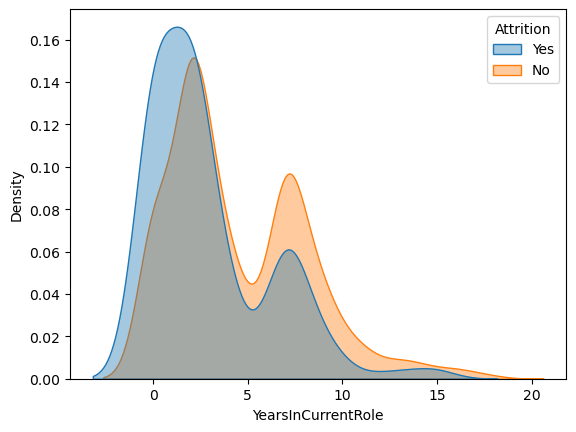

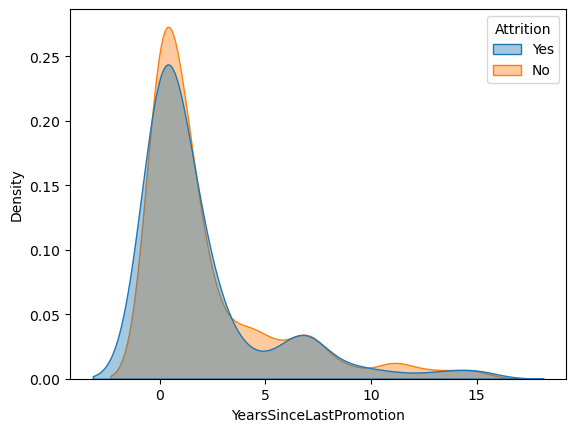

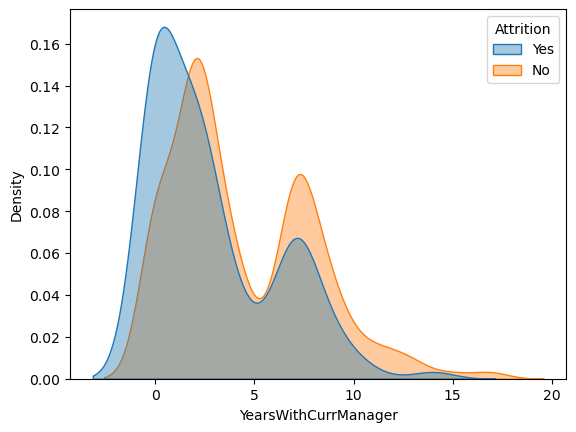

In [97]:
for name in num_cols:
    sns.kdeplot(data=data, x=name, hue="Attrition", fill=True, common_norm=False, alpha=0.4)
    plt.show()

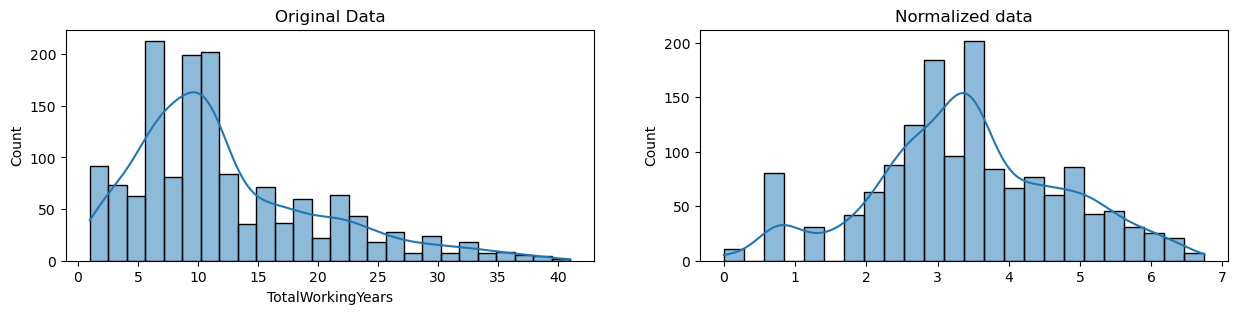

In [98]:
original_data = data.TotalWorkingYears + 1
normalized_data, best_lambda = stats.boxcox(original_data)

#hue="Attrition",

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(normalized_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

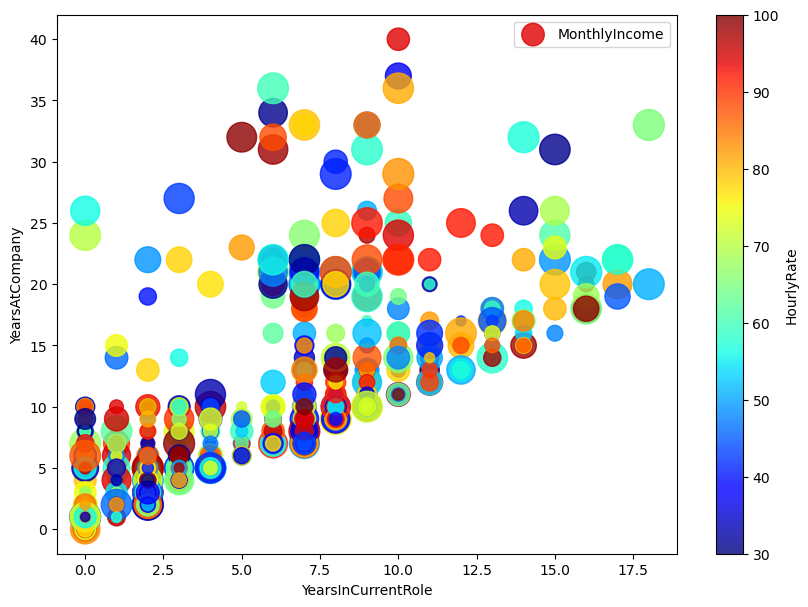

In [99]:
data["MonthlyIncomea"] = data["MonthlyIncome"] / 40
data.plot(kind="scatter", x="YearsInCurrentRole", y="YearsAtCompany", alpha=0.8,
             s=data["MonthlyIncomea"], label="MonthlyIncome", figsize=(10,7),
             c="HourlyRate", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();
data = data.drop(['MonthlyIncomea'], axis = 1)

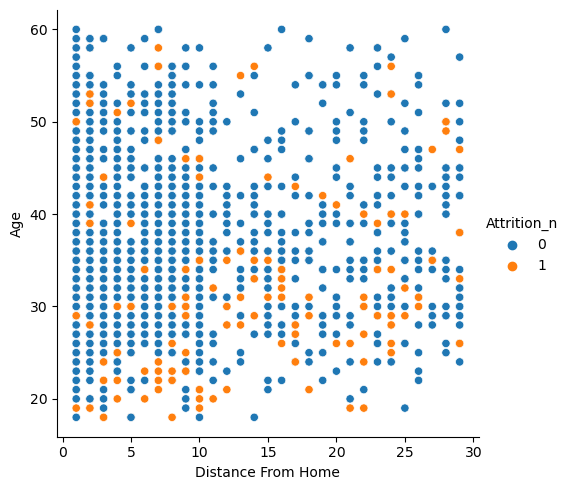

In [100]:
sns.relplot(x='DistanceFromHome',
            y='Age',
            data=data,
            kind='scatter',
            hue='Attrition_n')
plt.ylabel("Age")
plt.xlabel("Distance From Home")
plt.show();

In [101]:
#num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',  'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',  'YearsWithCurrManager']
#sns.pairplot(data[num_cols + ['Attrition_n']], hue = 'Attrition_n')
#plt.show()

## Categorial data

In [102]:
cat_cols = list(data.select_dtypes(include=['object']))
cat_cols

['Attrition',
 'BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'OverTime',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'WorkLifeBalance']

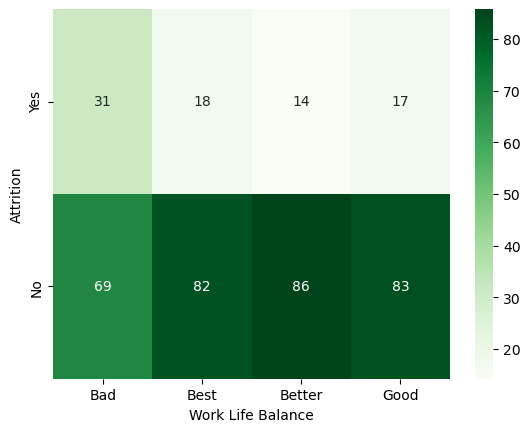

In [103]:
re_data = data.copy()
re_data.rename(columns = {'BusinessTravel':'Business Travel',
                          'EducationField':'Education Field',
                          'EnvironmentSatisfaction':'Environment Satisfaction', 
                          'JobInvolvement':'Job Involvement',
                          'JobLevel':'Job Level',
                          'JobRole':'Job Role',
                          'JobSatisfaction':'Job Satisfaction',
                          'MaritalStatus':'Marital Status',
                          'OverTime':'Over Time',
                          'PerformanceRating':'Performance Rating',
                          'RelationshipSatisfaction':'Relationship Satisfaction',
                          'StockOptionLevel':'Stock Option Level',
                          'WorkLifeBalance':'Work Life Balance'}, inplace = True)
room_t = pd.DataFrame(pd.crosstab(re_data['Attrition'], re_data['Work Life Balance'], normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

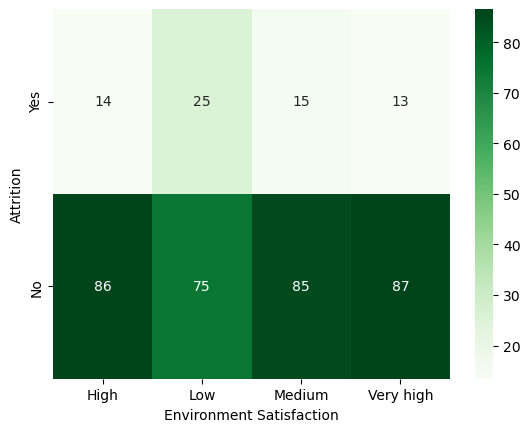

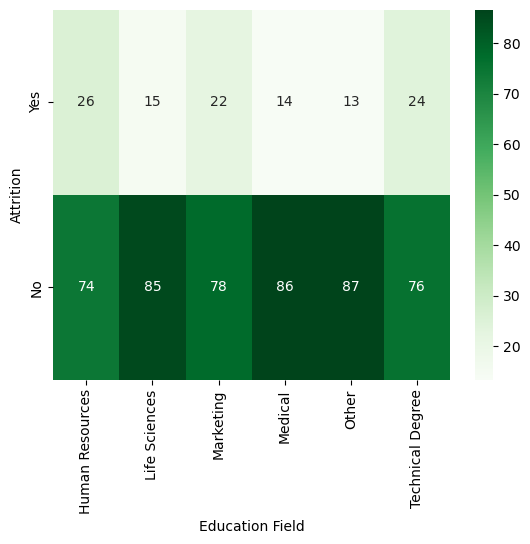

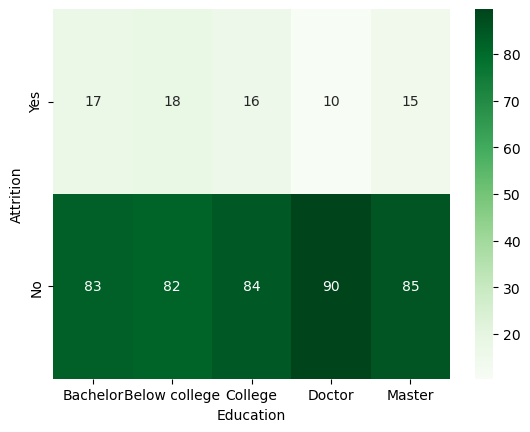

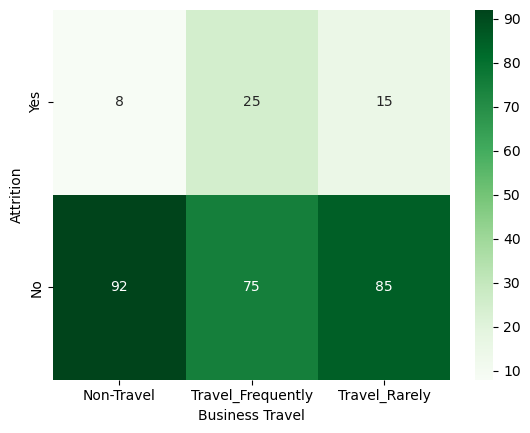

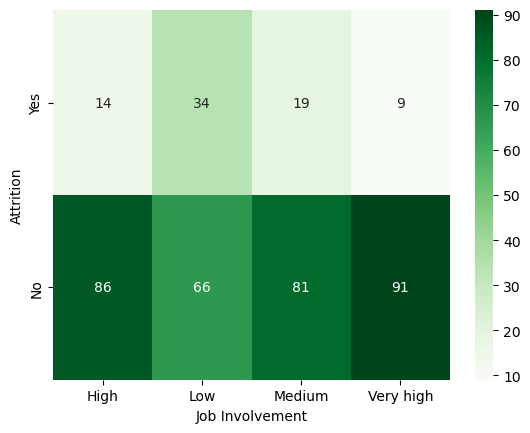

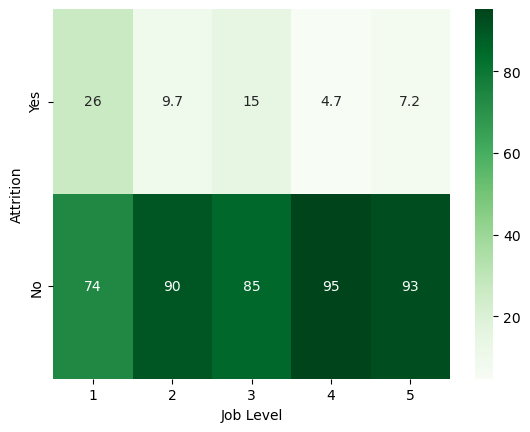

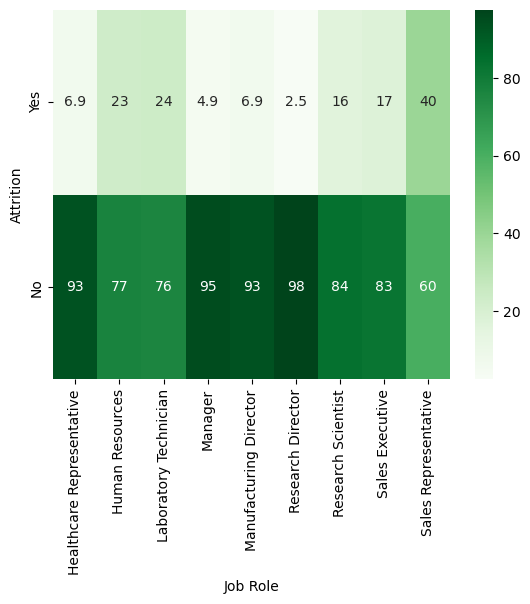

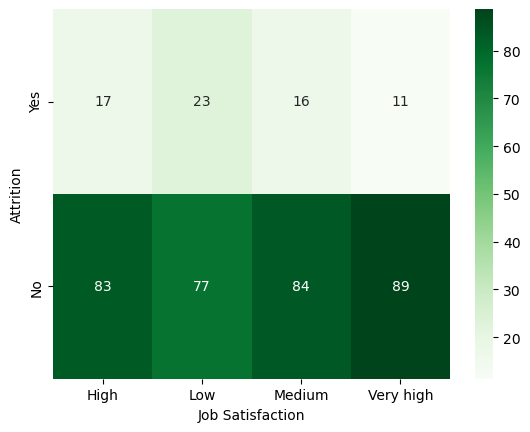

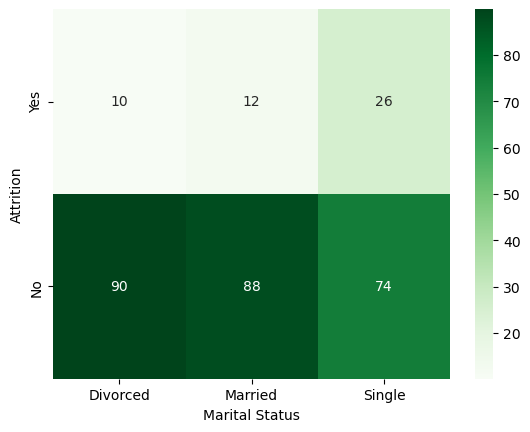

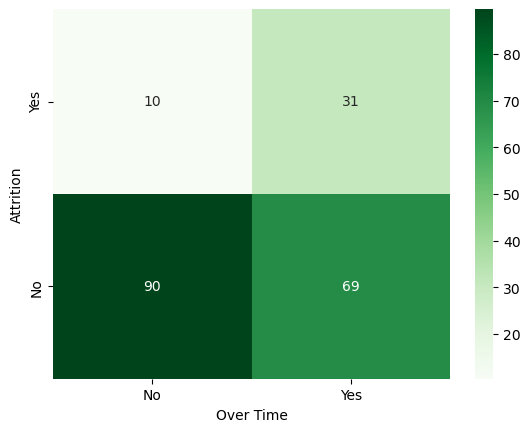

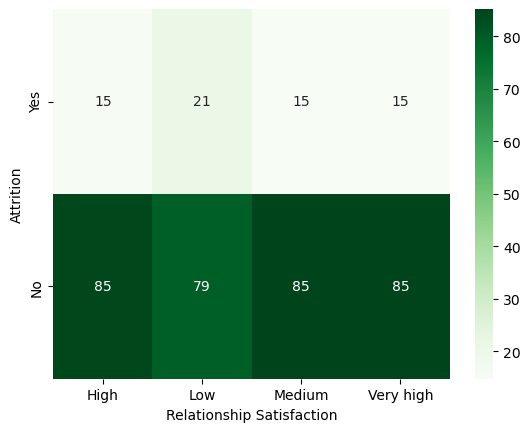

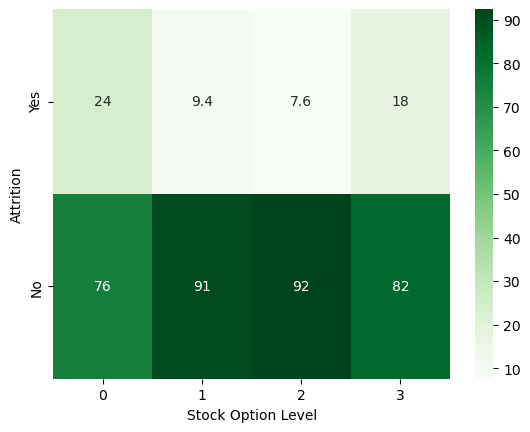

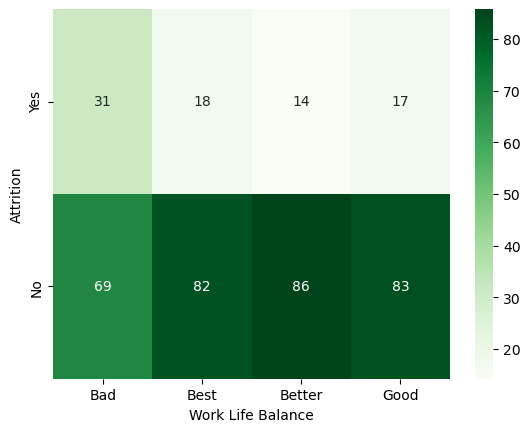

In [104]:
for name in ['Environment Satisfaction','Education Field','Education','Business Travel',
             'Job Involvement','Job Level','Job Role','Job Satisfaction','Marital Status',
             'Over Time','Relationship Satisfaction','Stock Option Level','Work Life Balance']:
    room_t = pd.DataFrame(pd.crosstab(re_data['Attrition'], re_data[name], normalize='columns'))
    room_t = room_t * 100

    ax = sns.heatmap(room_t, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

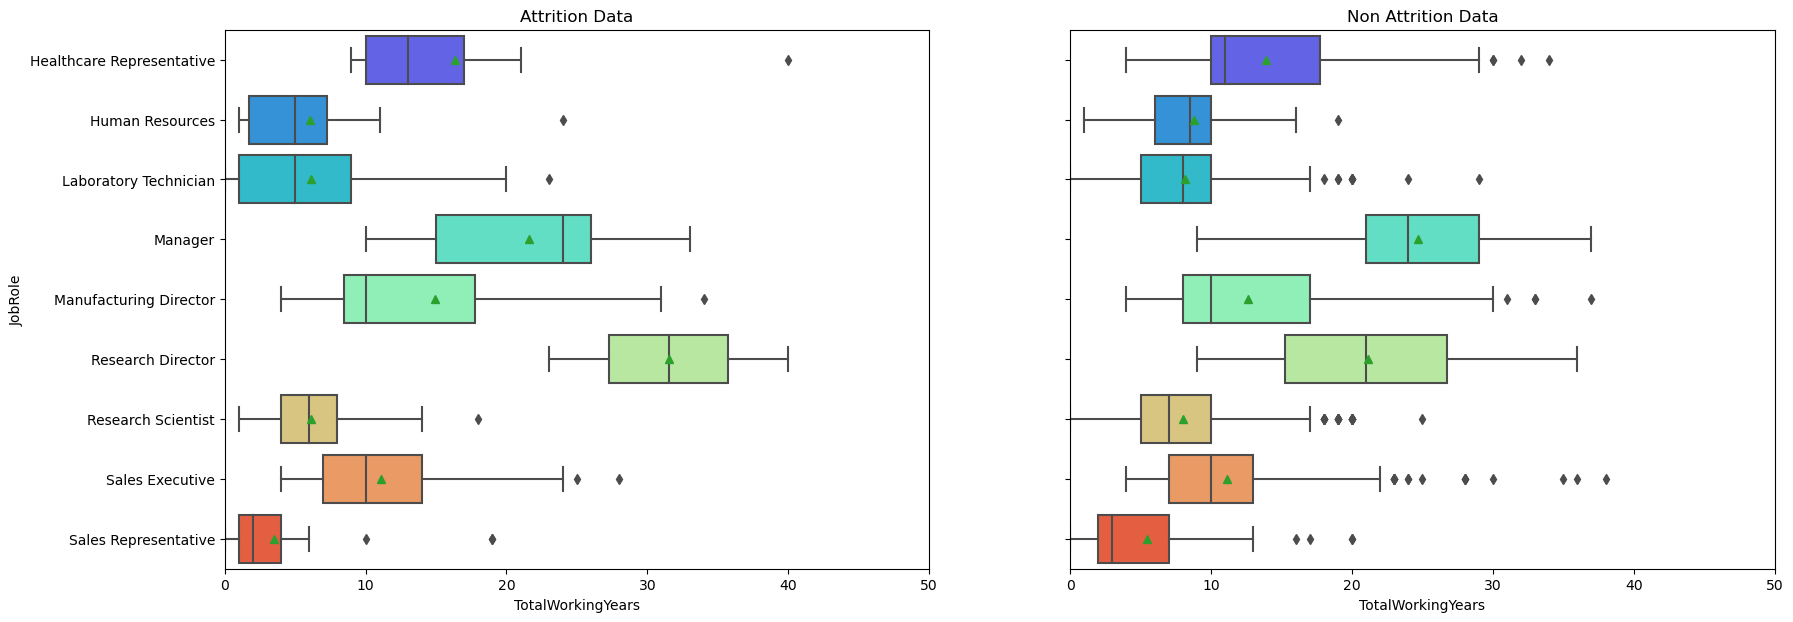

In [105]:
fig, ax=plt.subplots(1, 2, figsize=(20, 7))
d1 = data[data.Attrition == 'Yes']
d1 = d1.sort_values(["JobRole"])
d2 = data[data.Attrition == 'No']
d2 = d2.sort_values(["JobRole"])
g1 = sns.boxplot(data=d1, x='TotalWorkingYears', y="JobRole", palette='rainbow', showmeans=True, ax=ax[0])
g1.set_title("Attrition Data")
g1.set_xlim(0, 50)

g2 = sns.boxplot(data=d2, x='TotalWorkingYears', y="JobRole", palette='rainbow', showmeans=True, ax=ax[1])
g2.set(ylabel=None)
g2.set(yticklabels=[]) 
g2.set_title("Non Attrition Data")
g2.set_xlim(0, 50)
plt.show()

## Test/Train split

In [106]:
print(list(data.columns))

['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_n']


In [107]:
y = data.Attrition_n
X = data.drop(['Attrition_n','Attrition'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (64215, 34) (42811, 34)

print('Cancellation rate train (%): ', round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100,2))
print('Cancellation rate test (%): ', round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

(882, 30) (588, 30)
Cancellation rate train (%):  16.1
Cancellation rate test (%):  16.16


In [108]:
print(list(X_train.columns))

['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


## Examine the features

In [109]:
y = y_train.copy()
X = X_train.copy()

#X.duration_bin = X.duration_bin.astype(object)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

In [110]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

MonthlyRate                 0.431890
MonthlyIncome               0.420888
DailyRate                   0.334233
Age                         0.048433
TotalWorkingYears           0.041906
HourlyRate                  0.040702
YearsAtCompany              0.032247
JobRole                     0.029555
OverTime                    0.028547
YearsWithCurrManager        0.026914
YearsInCurrentRole          0.024002
JobLevel                    0.023256
DistanceFromHome            0.019000
StockOptionLevel            0.017655
MaritalStatus               0.015779
NumCompaniesWorked          0.014491
YearsSinceLastPromotion     0.013528
JobInvolvement              0.008868
EnvironmentSatisfaction     0.006785
JobSatisfaction             0.006212
BusinessTravel              0.006192
TrainingTimesLastYear       0.006034
PercentSalaryHike           0.005858
WorkLifeBalance             0.005069
RelationshipSatisfaction    0.004424
Department                  0.004398
EducationField              0.003627
E

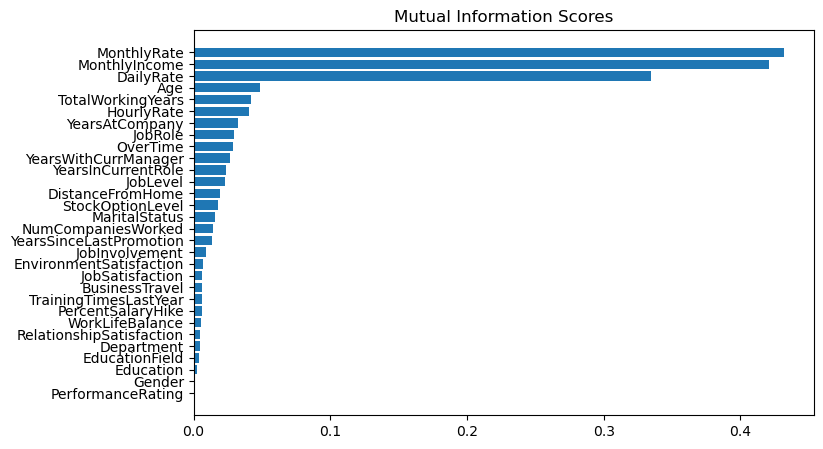

In [111]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

## Features from tree classification

In [112]:
#num_cols.remove('Attrition_n')
print(num_cols)

['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [113]:
X = X_train[num_cols]
y = y_train

clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(X, y)

In [114]:
text_representation = tree.export_text(clf, feature_names=list(X.columns))
#print(text_representation)

In [115]:
#rules, proba = get_rules(clf, list(X.columns), [0,1], 80, 100)

In [116]:
rule_lst = []
flattened_lst = []

minutes = 0.5
t_end = time.time() + 60 * minutes

while time.time() < t_end:
    rules, proba = get_rules(clf, list(X.columns), [0,1], 80, 10)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

In [117]:
#flattened_lst

## New features

In [118]:
new_f('RS_TWH', 'Research Scientist', 'TotalWorkingYears', 'JobRole')    
new_f('HR_TWH', 'Human Resources', 'TotalWorkingYears', 'JobRole')    
new_f('SR_TWH', 'Sales Representative', 'TotalWorkingYears', 'JobRole')    
new_f('SE_TWH', 'Sales Executive', 'TotalWorkingYears', 'JobRole')    
new_f('LT_TWH', 'Laboratory Technician', 'TotalWorkingYears', 'JobRole')    

#X_train['HR_TWH'] = 0
#X_train.loc[X_train.JobRole == 'Human Resources', 'HR_TWH'] = X_train.TotalWorkingYears

#X_train['SR_TWH'] = 0
#X_train.loc[X_train.JobRole == 'Sales Representative', 'SR_TWH'] = X_train.TotalWorkingYears

#X_train['SE_TWH'] = 0
#X_train.loc[X_train.JobRole == 'Sales Executive', 'SE_TWH'] = X_train.TotalWorkingYears

#X_train['LT_TWH'] = 0
#X_train.loc[X_train.JobRole == 'Laboratory Technician', 'LT_TWH'] = X_train.TotalWorkingYears
print(list(X_train.columns))

['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'RS_TWH', 'HR_TWH', 'SR_TWH', 'SE_TWH', 'LT_TWH']


In [119]:
#pd.crosstab(X_train.JobRole, columns = 'Count')

In [120]:
X_train['feature_1'] = 0
X_train.loc[(X_train.TotalWorkingYears > 1.5) & 
            (X_train.MonthlyIncome > 2437.5) & 
            (X_train.MonthlyIncome <= 10003.0) & 
            (X_train.YearsWithCurrManager > 7.5), 'feature_1'] = 1

X_train['feature_2'] = 0
X_train.loc[(X_train.TotalWorkingYears > 1.5) &
            (X_train.MonthlyIncome > 10854.5) & 
            (X_train.MonthlyIncome <= 19755.0) &
            (X_train.DailyRate <= 1448.5), 'feature_2'] = 1

X_train['feature_3'] = 0
X_train.loc[(X_train.TotalWorkingYears > 1.5) & 
            (X_train.MonthlyIncome <= 2437.5) & 
            (X_train.YearsWithCurrManager > 0.5) & 
            (X_train.HourlyRate <= 98.5) &
            (X_train.YearsInCurrentRole > 2.5), 'feature_3'] = 1

X_train['feature_4'] = 0
X_train.loc[(X_train.TotalWorkingYears <= 1.5) & 
            (X_train.Age <= 29.5) & 
            (X_train.MonthlyIncome > 1566.0) & 
            (X_train.DailyRate <= 1038.0) & 
            (X_train.MonthlyIncome <= 2793.5), 'feature_4'] = 1


In [121]:
X_test['feature_1'] = 0
X_test.loc[(X_test.TotalWorkingYears > 1.5) & 
            (X_test.MonthlyIncome > 2437.5) & 
            (X_test.MonthlyIncome <= 10003.0) & 
            (X_test.YearsWithCurrManager > 7.5), 'feature_1'] = 1

X_test['feature_2'] = 0
X_test.loc[(X_test.TotalWorkingYears > 1.5) &
            (X_test.MonthlyIncome > 10854.5) & 
            (X_test.MonthlyIncome <= 19755.0) &
            (X_test.DailyRate <= 1448.5), 'feature_2'] = 1

X_test['feature_3'] = 0
X_test.loc[(X_test.TotalWorkingYears > 1.5) & 
            (X_test.MonthlyIncome <= 2437.5) & 
            (X_test.YearsWithCurrManager > 0.5) & 
            (X_test.HourlyRate <= 98.5) &
            (X_test.YearsInCurrentRole > 2.5), 'feature_3'] = 1

X_test['feature_4'] = 0
X_test.loc[(X_test.TotalWorkingYears <= 1.5) & 
            (X_test.Age <= 29.5) & 
            (X_test.MonthlyIncome > 1566.0) & 
            (X_test.DailyRate <= 1038.0) & 
            (X_test.MonthlyIncome <= 2793.5), 'feature_4'] = 1


In [122]:
#pd.crosstab(X_train['feature_4'], columns = 'Count')

## Binning data

In [123]:
m_val_lst = ['Age','MonthlyRate','MonthlyIncome','DailyRate', 'HourlyRate']

for m_val in m_val_lst:
    X_train[m_val + '_bin'], bin_edges  = pd.qcut(X_train[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)
    
    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'
    


Age [18. 26. 29. 31. 33. 36. 38. 41. 45. 51. 60.] range(0, 10)
MonthlyRate [ 2104.   4546.3  6896.6  9150.  11738.2 14232.  16824.6 19371.5 21697.
 24015.4 26999. ] range(0, 10)
MonthlyIncome [ 1009.   2326.2  2703.   3428.4  4269.6  4948.   5766.8  6918.2  9880.8
 13590.1 19999. ] range(0, 10)
DailyRate [ 103.   266.   406.4  525.3  640.4  791.   951.8 1104.4 1239.8 1361.9
 1498. ] range(0, 10)
HourlyRate [ 30.   37.   44.   51.   57.4  65.   73.   80.   87.   95.  100. ] range(0, 10)


In [124]:
print(list(set(X_test['MonthlyRate_bin'])))
a = X_test[X_test['HourlyRate_bin'] == 'Missing']
a[['HourlyRate_bin','HourlyRate']]

['2', '3', '1', '5', '6', '0', '8', 'Missing', '4', '7', '9']


Empty DataFrame
Columns: [HourlyRate_bin, HourlyRate]
Index: []

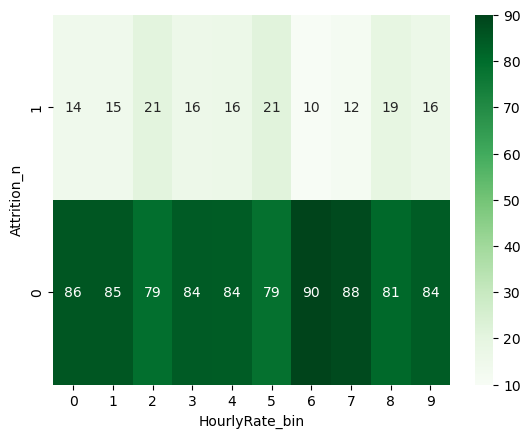

In [125]:
pd.crosstab(X_train[m_val + '_bin'], columns = 'Count')

re_data = pd.concat([X_train,y_train], axis = 1)

room_t = pd.DataFrame(pd.crosstab(re_data['Attrition_n'], re_data['HourlyRate_bin'], normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

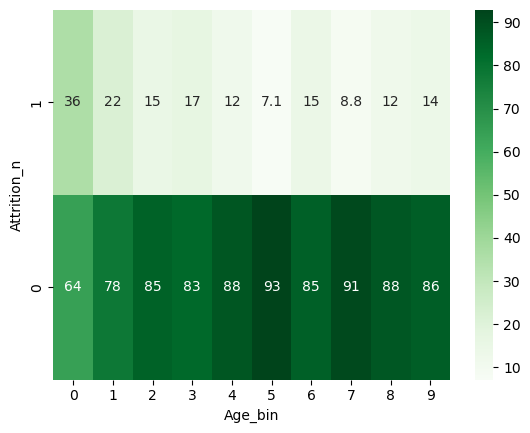

In [126]:
rdata = pd.concat([X_train,y_train], axis = 1)
room_t = pd.DataFrame(pd.crosstab(rdata['Attrition_n'], rdata['Age_bin'], normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

## Preprocess the model data

In [127]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['Age', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'HourlyRate'], axis = 1)
X_test = X_test.drop(['Age', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'HourlyRate'], axis = 1)

['Age', 'Age_bin', 'BusinessTravel', 'DailyRate', 'DailyRate_bin', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HR_TWH', 'HourlyRate', 'HourlyRate_bin', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'LT_TWH', 'MaritalStatus', 'MonthlyIncome', 'MonthlyIncome_bin', 'MonthlyRate', 'MonthlyRate_bin', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RS_TWH', 'RelationshipSatisfaction', 'SE_TWH', 'SR_TWH', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


In [128]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

[]


In [129]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif.sort_values(['VIF'], ascending = False)

['YearsAtCompany']


Features        VIF
5            YearsAtCompany  10.168038
3         TotalWorkingYears   8.981419
2         PercentSalaryHike   7.767547
8      YearsWithCurrManager   7.162944
6        YearsInCurrentRole   6.679144
4     TrainingTimesLastYear   4.793247
1        NumCompaniesWorked   2.697466
7   YearsSinceLastPromotion   2.547720
15                feature_2   2.518602
0          DistanceFromHome   2.225162
14                feature_1   1.680469
12                   SE_TWH   1.611325
9                    RS_TWH   1.503760
13                   LT_TWH   1.429156
11                   SR_TWH   1.133940
16                feature_3   1.118654
10                   HR_TWH   1.100362
17                feature_4   1.060468

[]


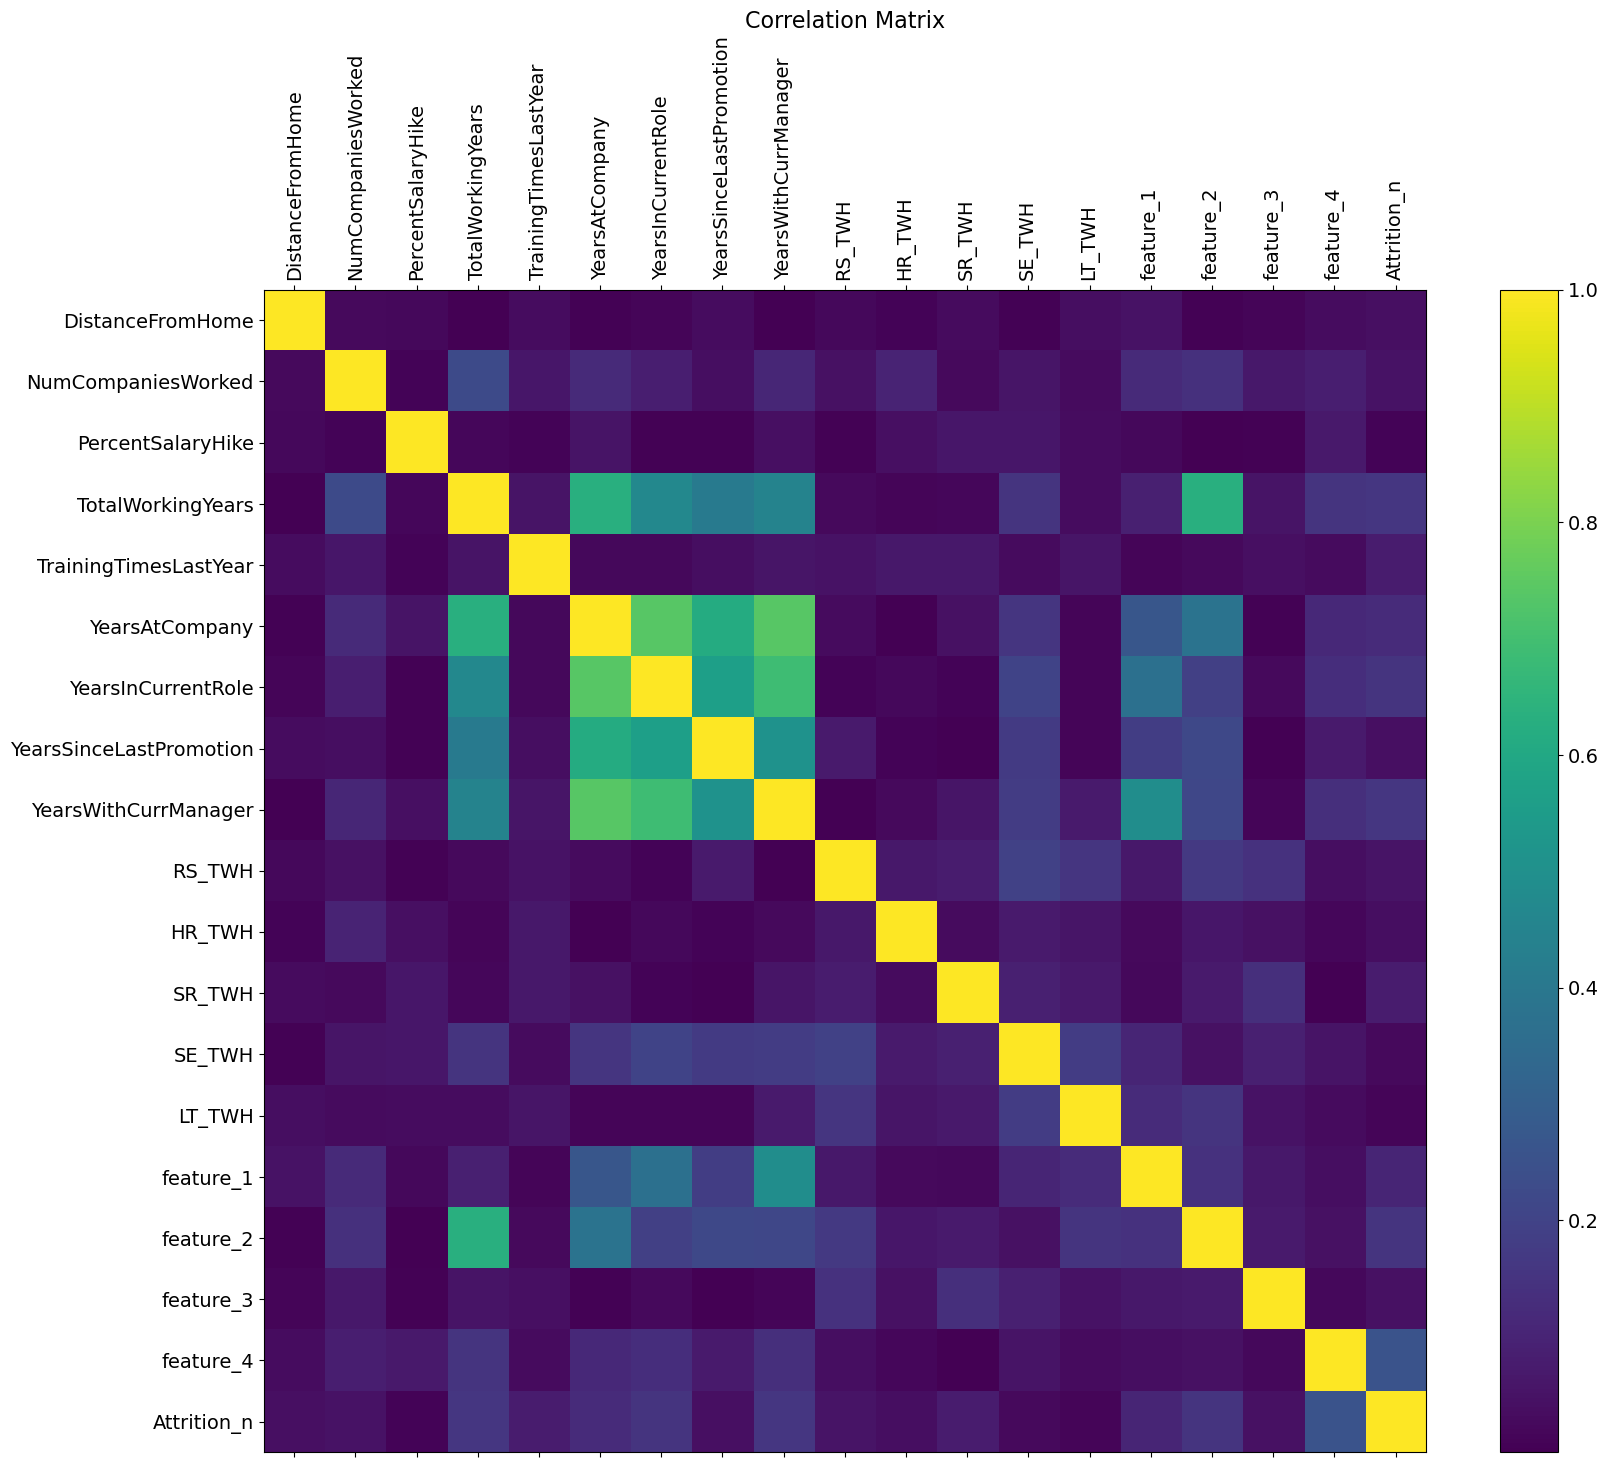

In [130]:
###################
### Correlation ###
###################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [131]:
#####################
### MinMax scaler ###
#####################

num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(882, 18)
(882, 18)
(588, 18)
Data min:max (0.0, 1.0)


In [132]:
################################### 
### High cardinality adjustment ###
################################### 

cat_cols = list(X_train.select_dtypes(include=['object']))

card_vars = []
cat_data = X_train[cat_cols]
cat_data_vals = cat_data.copy()
for i in range(cat_data.shape[1]):
    print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))        
    if (len(list(set(cat_data.iloc[:,i]))) > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))        

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')        
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        cat_data_vals.loc[~cat_data_vals[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        
    elif cat_data.iloc[:,i].nunique() > 100:
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))     
        card_vars.append(cat_data.columns[i])

print(card_vars)

BusinessTravel 3
Department 3
Education 5
EducationField 6
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobLevel 5
JobRole 9
JobSatisfaction 4
MaritalStatus 3
OverTime 2
PerformanceRating 2
RelationshipSatisfaction 4
StockOptionLevel 4
WorkLifeBalance 4
Age_bin 10
MonthlyRate_bin 10
MonthlyIncome_bin 10
DailyRate_bin 10
HourlyRate_bin 10
[]


In [133]:
########################
### One hot encoding ###
########################

cat_cols = list(X_train.select_dtypes(include=['object']))

ohe_cols = (list(set(cat_cols) - set(['Education','EnvironmentSatisfaction','JobInvolvement',
                                      'JobSatisfaction','WorkLifeBalance','RelationshipSatisfaction',
                                      'PerformanceRating', 'Age_bin','MonthlyRate_bin','MonthlyIncome_bin',
                                      'DailyRate_bin', 'HourlyRate_bin'])))


ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[ohe_cols])
colnames = ohe.get_feature_names_out(ohe_cols)

cat_data_train = ohe_dset(X_train,ohe_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test,ohe_cols)    ### Test ###

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(882, 39)
(882, 37)
(588, 37)
(882, 37)
Data min:max (0, 1)


In [134]:
#cat_cols
pd.crosstab(X_train['DailyRate_bin'], columns = 'Count')
#pd.crosstab(X_train['DailyRate_bin'].isna(), columns = 'Count')
# 'Age', 'DailyRate', 'MonthlyIncome', 'MonthlyRate', 'HourlyRate'

col_0          Count
DailyRate_bin       
0                 90
1                 87
2                 88
3                 88
4                 89
5                 87
6                 88
7                 88
8                 88
9                 89

In [135]:
a = list(X_train.columns)
a.sort()
print(a)

['Age_bin', 'BusinessTravel', 'DailyRate_bin', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HR_TWH', 'HourlyRate_bin', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'LT_TWH', 'MaritalStatus', 'MonthlyIncome_bin', 'MonthlyRate_bin', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RS_TWH', 'RelationshipSatisfaction', 'SE_TWH', 'SR_TWH', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'feature_1', 'feature_2', 'feature_3', 'feature_4']


In [136]:
check = X_test.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/X_test.shape[0]*100
check

Count  perc
BusinessTravel                0   0.0
Department                    0   0.0
DistanceFromHome              0   0.0
Education                     0   0.0
EducationField                0   0.0
EnvironmentSatisfaction       0   0.0
Gender                        0   0.0
JobInvolvement                0   0.0
JobLevel                      0   0.0
JobRole                       0   0.0
JobSatisfaction               0   0.0
MaritalStatus                 0   0.0
NumCompaniesWorked            0   0.0
OverTime                      0   0.0
PercentSalaryHike             0   0.0
PerformanceRating             0   0.0
RelationshipSatisfaction      0   0.0
StockOptionLevel              0   0.0
TotalWorkingYears             0   0.0
TrainingTimesLastYear         0   0.0
WorkLifeBalance               0   0.0
YearsAtCompany                0   0.0
YearsInCurrentRole            0   0.0
YearsSinceLastPromotion       0   0.0
YearsWithCurrManager          0   0.0
RS_TWH                        0   0.0
HR_TWH                        0   0.0
SR_TWH                        0   0.0
SE_TWH                        0   0.0
LT_TWH                        0   0.0
feature_1                     0   0.0
feature_2                     0   0.0
feature_3                     0   0.0
feature_4                     0   0.0
Age_bin                       0   0.0
MonthlyRate_bin               0   0.0
MonthlyIncome_bin             0   0.0
DailyRate_bin                 0   0.0
HourlyRate_bin                0   0.0

In [137]:
ordinal_encoder_m = OrdinalEncoder(categories=[['Below college','College','Bachelor','Master','Doctor']])
ordinal_encoder_m.fit(pd.DataFrame(X_train['Education']))
ord_data_train = pd.DataFrame(ordinal_encoder_m.transform(pd.DataFrame(X_train['Education'])),columns = ['Education'])

ordinal_encoder_pr = OrdinalEncoder(categories=[['Low','Good','Excellent','Outstanding']])
ordinal_encoder_pr.fit(pd.DataFrame(X_train['PerformanceRating']))
ord_data_train['PerformanceRating'] = pd.DataFrame(ordinal_encoder_pr.transform(pd.DataFrame(X_train['PerformanceRating'])))

ordinal_encoder_wlb = OrdinalEncoder(categories=[['Bad','Good','Better','Best']])
ordinal_encoder_wlb.fit(pd.DataFrame(X_train['WorkLifeBalance']))
ord_data_train['WorkLifeBalance'] = pd.DataFrame(ordinal_encoder_wlb.transform(pd.DataFrame(X_train['WorkLifeBalance'])))

ordinal_encoder_d = OrdinalEncoder(categories=[['Low','Medium','High','Very high']])
ordinal_encoder_d.fit(pd.DataFrame(X_train['EnvironmentSatisfaction']))
ord_data_train['EnvironmentSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_train['EnvironmentSatisfaction'])))

ordinal_encoder_d.fit(pd.DataFrame(X_train['JobInvolvement']))
ord_data_train['JobInvolvement'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_train['JobInvolvement'])))

ordinal_encoder_d.fit(pd.DataFrame(X_train['JobSatisfaction']))
ord_data_train['JobSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_train['JobSatisfaction'])))

ordinal_encoder_d.fit(pd.DataFrame(X_train['RelationshipSatisfaction']))
ord_data_train['RelationshipSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_train['RelationshipSatisfaction'])))

ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['Age_bin']))
ord_data_train['Age_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['Age_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['DailyRate_bin']))
ord_data_train['DailyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['DailyRate_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['MonthlyIncome_bin']))
ord_data_train['MonthlyIncome_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['MonthlyIncome_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['MonthlyRate_bin']))
ord_data_train['MonthlyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['MonthlyRate_bin'])))

ordinal_encoder_bin.fit(pd.DataFrame(X_train['HourlyRate_bin']))
ord_data_train['HourlyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['HourlyRate_bin'])))

for name in ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
             'WorkLifeBalance','RelationshipSatisfaction','PerformanceRating',
             'Age_bin', 'DailyRate_bin', 'MonthlyIncome_bin', 'MonthlyRate_bin',
             'HourlyRate_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
                          'WorkLifeBalance','RelationshipSatisfaction','PerformanceRating',
                          'Age_bin', 'DailyRate_bin', 'MonthlyIncome_bin', 'MonthlyRate_bin',
                          'HourlyRate_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

ord_data_test = pd.DataFrame(ordinal_encoder_m.transform(pd.DataFrame(X_test['Education'])),columns = ['Education'])

ord_data_test['EnvironmentSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_test['EnvironmentSatisfaction'])))
ord_data_test['PerformanceRating'] = pd.DataFrame(ordinal_encoder_pr.transform(pd.DataFrame(X_test['PerformanceRating'])))
ord_data_test['WorkLifeBalance'] = pd.DataFrame(ordinal_encoder_wlb.transform(pd.DataFrame(X_test['WorkLifeBalance'])))
ord_data_test['JobInvolvement'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_test['JobInvolvement'])))
ord_data_test['JobSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_test['JobSatisfaction'])))
ord_data_test['RelationshipSatisfaction'] = pd.DataFrame(ordinal_encoder_d.transform(pd.DataFrame(X_test['RelationshipSatisfaction'])))

ord_data_test['Age_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['Age_bin'])))
ord_data_test['DailyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['DailyRate_bin'])))
ord_data_test['MonthlyIncome_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['MonthlyIncome_bin'])))
ord_data_test['MonthlyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['MonthlyRate_bin'])))
ord_data_test['HourlyRate_bin'] = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['HourlyRate_bin'])))


for name in ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
             'WorkLifeBalance','RelationshipSatisfaction','PerformanceRating',
             'Age_bin', 'DailyRate_bin', 'MonthlyIncome_bin', 'MonthlyRate_bin',
             'HourlyRate_bin']:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction',
                         'WorkLifeBalance','RelationshipSatisfaction','PerformanceRating',
                         'Age_bin', 'DailyRate_bin', 'MonthlyIncome_bin', 'MonthlyRate_bin',
                         'HourlyRate_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

ord_data_test.head()

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- EnvironmentSatisfaction
Feature names seen at fit time, yet now missing:
- RelationshipSatisfaction

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- JobInvolvement
Feature names seen at fit time, yet now missing:
- RelationshipSatisfaction

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- JobSatisfaction
Feature names seen at fit time, yet now missing:
- RelationshipSatisfaction

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Age_bin
Feature names seen at fit time, yet now missing:
- HourlyRate_bin

The feature names should match those that w

Education  EnvironmentSatisfaction  JobInvolvement  JobSatisfaction  \
0       0.75                 1.000000             0.0         0.666667   
1       0.50                 0.000000             0.0         0.666667   
2       0.50                 1.000000             0.0         1.000000   
3       0.75                 1.000000             0.0         0.666667   
4       0.50                 0.666667             1.0         0.333333   

   WorkLifeBalance  RelationshipSatisfaction  PerformanceRating   Age_bin  \
0         0.666667                  0.666667           0.333333  0.333333   
1         0.666667                  0.333333           0.666667  0.666667   
2         0.333333                  1.000000           0.666667  0.888889   
3         0.666667                  1.000000           0.666667  0.333333   
4         0.333333                  1.000000           0.333333  0.222222   

   DailyRate_bin  MonthlyIncome_bin  MonthlyRate_bin  HourlyRate_bin  
0            0.8           0.333333              0.4        0.555556  
1            0.1           0.777778              0.4        0.333333  
2            0.5           1.000000              0.3        0.666667  
3            0.2           0.555556              0.1        0.888889  
4            0.6           0.666667              0.8        0.333333

In [138]:
#ord_data_train[['Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','WorkLifeBalance','RelationshipSatisfaction','PerformanceRating']].head()

In [139]:
#num_data_train.head()

In [140]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, ord_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()

X_train_mod = pd.concat([cat_data_train,num_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,ord_data_train],axis = 1)
print(X_train_mod.shape)

print(cat_data_test.shape, num_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
X_test_mod = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,ord_data_test],axis = 1)
print(X_test_mod.shape)

#cat_data_oot = cat_data_oot.reset_index()
#num_data_oot = num_data_oot.reset_index()
#X_oot = pd.concat([cat_data_oot,num_data_oot],axis = 1)
print(X_train_mod.shape, X_test_mod.shape)

(882, 37) (882, 18) (882, 12)
(882, 70)
(588, 37) (588, 18)
(588, 69)
(882, 70) (588, 69)


In [141]:
####################################################
### Check that train/test sets have same columns ###
####################################################

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('index')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod
    
try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('level_0')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(882, 67) (588, 67)


In [142]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Age_bin', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'DailyRate_bin', 'Department_Human_Resources', 'Department_Research__Development', 'Department_Sales', 'DistanceFromHome', 'Education', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'EnvironmentSatisfaction', 'Gender_Female', 'Gender_Male', 'HR_TWH', 'HourlyRate_bin', 'JobInvolvement', 'JobLevel_1', 'JobLevel_2', 'JobLevel_3', 'JobLevel_4', 'JobLevel_5', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'JobSatisfaction', 'LT_TWH', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MonthlyIncome_bin', 'Monthly

## Models

In [143]:
############################################
### Check the accuracy on all the models ###
############################################

models = select_model(X_train_mod, y_train)

`use_label_encoder` is deprecated in 1.7.0.
  0%|          | 0/13 [00:00<?, ?it/s]`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
100%|██████████| 13/13 [00:34<00:00,  2.66s/it]


In [144]:
models.head(20)

model run_time  accuracy
0          RidgeClassifier      0.0  0.830676
1            SGDClassifier      0.0  0.821570
2              BernoulliNB      0.0  0.810328
12      CatBoostClassifier     0.29  0.788784
3   RandomForestClassifier      0.2  0.776596
4       AdaBoostClassifier     0.02  0.773700
5           LGBMClassifier     0.01  0.773539
6            XGBClassifier     0.04  0.759916
7     KNeighborsClassifier      0.0  0.681786
8   DecisionTreeClassifier      0.0  0.614505
9     ExtraTreesClassifier      0.0  0.604228
10     ExtraTreeClassifier      0.0  0.599730
11         DummyClassifier      0.0  0.500000

In [145]:
######################################
### CatBoost hyperparameter tuning ###
######################################

pbounds = {"n_estimators": (150,400),
           "depth": (2,7),
           "learning_rate": (0.01, 0.2),
           "subsample":(0.6, 1.0),
           "num_leaves": (16,40),
           "max_bin":(150,300),
           "l2_leaf_reg":(2,10),
           "model_size_reg": (0,10)
}
optimizer = BayesianOptimization(
    f = CB_opt,
    pbounds = pbounds,
    verbose = 2,
    random_state = 888,
)

optimizer.maximize(init_points = 15, n_iter = 25)

print(optimizer.max)


print("CV score: {:<8.5f}".format(CB_opt(int(optimizer.max['params']['n_estimators']),
                                         round(optimizer.max['params']['depth'],0),
                                         optimizer.max['params']['learning_rate'],
                                         round(optimizer.max['params']['max_bin'],0),
                                         optimizer.max['params']['subsample'],
                                         round(optimizer.max['params']['num_leaves'],0),
                                         optimizer.max['params']['l2_leaf_reg'],
                                         optimizer.max['params']['model_size_reg'])))

###########################
### Fit the tuned model ###
###########################

cboost_model_hy = CatBoostClassifier(depth = round(optimizer.max['params']['depth'],0),
                                    l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'],
                                    learning_rate = optimizer.max['params']['learning_rate'],
                                    max_bin = round(optimizer.max['params']['max_bin'],0),
                                    n_estimators = int(optimizer.max['params']['n_estimators']),
                                    num_leaves = round(optimizer.max['params']['num_leaves'],0),
                                    subsample = optimizer.max['params']['subsample'],
                                    random_state = 88,
                                    grow_policy = "Lossguide",
                                    verbose = 0,
                                    eval_metric = "AUC")

|   iter    |  target   |   depth   | l2_lea... | learni... |  max_bin  | model_... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.5783    | 6.298     | 3.317     | 0.1019    | 288.2     | 4.286     | 164.4     | 38.2      | 0.863     |
| 2         | 0.6171    | 2.665     | 6.268     | 0.1809    | 187.3     | 0.3017    | 168.1     | 36.98     | 0.8234    |
| 3         | 0.5546    | 6.58      | 7.068     | 0.06382   | 204.8     | 0.9223    | 243.1     | 24.34     | 0.8821    |
| 4         | 0.6037    | 5.243     | 2.327     | 0.05023   | 150.2     | 1.39      | 203.0     | 16.63     | 0.7784    |
| 5         | 0.6086    | 3.196     | 9.636     | 0.1825    | 279.4     | 0.9159    | 394.4     | 25.88     | 0.7833    |
| 6         | 0.6206    | 4.63      | 4.355     | 0.1947    | 177.2     | 3.034     | 193.6     | 28.66     | 0.6083    |
| 7         | 0.6095    

CV score: 0.59738 


In [146]:
#################################
### LGBM Hyperparamter tuning ###
#################################

import lightgbm as lgb

%time

### prepare data ###

train_data = lgb.Dataset(data = X_train_mod,
                         label = y_train,
                         free_raw_data = False)

### parameters ###

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                        'num_leaves': (24, 80),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 30),
                                        'max_bin':(20,90),
                                        'min_data_in_leaf': (20, 80),
                                        'min_sum_hessian_in_leaf':(0,100),
                                        'subsample': (0.01, 1.0)},
                             random_state=200)


lgbBO.maximize(init_points = 15,
               n_iter = 25)

model_auc=[]
for model in range(len( lgbBO.res)):
    model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
opt_params_lbgm = lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params_lbgm[1]["num_leaves"] = int(round(opt_params_lbgm[1]["num_leaves"]))
opt_params_lbgm[1]['max_depth'] = int(round(opt_params_lbgm[1]['max_depth']))
opt_params_lbgm[1]['min_data_in_leaf'] = int(round(opt_params_lbgm[1]['min_data_in_leaf']))
opt_params_lbgm[1]['max_bin'] = int(round(opt_params_lbgm[1]['max_bin']))
opt_params_lbgm[1]['objective']='binary'
opt_params_lbgm[1]['metric']='auc'
opt_params_lbgm[1]['is_unbalance']=True
opt_params_lbgm[1]['boost_from_average']=False
opt_params_lbgm = opt_params_lbgm[1]

print(opt_params_lbgm)

folds = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=31416)
folds.get_n_splits(X_train_mod, y_train)

oof = np.zeros(len(X_train_mod))
predictions = np.zeros(len(X_test_mod))

for train_index, test_index in folds.split(X_train_mod, y_train):

    trainx, x_test_cv = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
    trainy, y_test_cv = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

    trn_data = lgb.Dataset(trainx,
                           label = trainy)
    val_data = lgb.Dataset(x_test_cv,
                           label = y_test_cv)

    num_round = 15000
    lbgm_model_hy = lgb.train(opt_params_lbgm,
                              trn_data,
                              num_round,
                              valid_sets = [trn_data, val_data],
                              verbose_eval = 500,
                              early_stopping_rounds = 250)

    oof[test_index] = lbgm_model_hy.predict(x_test_cv, num_iteration = lbgm_model_hy.best_iteration)

    predictions += lbgm_model_hy.predict(X_test_mod, num_iteration = lbgm_model_hy.best_iteration) / folds.n_splits
    pred_labels = np.rint(predictions)

print("CV score: {:<8.5f}".format(roc_auc_score(y_test,predictions)))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 2         | 0.7704    | 0.9964    | 0.7939    | 0.9862    | 84.63     | 12.59     | 70.77     | 12.12     | 67.99     | 0.258     |
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_fraction=0.8192059420307759
[LightGBM] [Warning] bagging_fraction is set=0.8192059420307759, subsample=0.4252313651032907 will be ignored. Current value: bagging_frac

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 794, number of used features: 60
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] Number of positive: 128, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Info] Number of positive: 128, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 794, number of used features: 60
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160151 -> initscore=-1.657103
[LightGBM] [Info] Start training from score -1.657103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160151 -> initscore=-1.657103
[LightGBM] [Info] Start training from score -1.657103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161209 -> initscore=-1.649259
[LightGBM] [Info] Start training from score -1.649259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161209 -> i

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 54
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Info] Number of positive: 127, number of negative: 666


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 54
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Info] Number of positive: 128, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Info] Number of positive: 127, number of negative: 666


[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 60
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8057987553580375, subsample=0.8880714853222914 will be ignored. Current value: bagging_fraction=0.8057987553580375
[LightGBM] [Warning] bagging_fraction is set=0.8057987553580375, subsample=0.8880714853222914 will be ignored. Current value: bagging_fraction=0.8057987553580375
[LightGBM] [Info] Number of positive: 128, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 794, number of used features: 56
[LightGBM] [Warning] bagging_fraction is set=0.8057987553580375, subsample=0.8880714853222914 will be ignored. Current value: bagging_fraction=0.8057987553580375
[LightGBM] [Warning] bagging_fraction is set=0.8057987553580375, subsample=0.8880714853222914 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900349197 will be ignored. Current value: bagging_fraction=0.8000632537506381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9962509111828415, subsample=0.8229620166457433 will be ignored. Current value: bagging_fraction=0.9962509111828415
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9962509111828415, subsample=0.8229620166457433 will be ignored. Current value: bagging_fraction=0.9962509111828415
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9962509111828415, subsample=0.8229620166457433 will be ignored. Current value: bagging_fraction=0.9962509111828415
[LightGBM] [Warning] Accuracy may be bad since you didn'

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.9962509111828415, subsample=0.8229620166457433 will be ignored. Current value: bagging_fraction=0.9962509111828415
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fract

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 19        | 0.7805    | 1.0       | 0.9       | 1.0       | 48.59     | 30.0      | 63.02     | 0.0       | 80.0      | 1.0       |
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[Ligh

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[L

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 22        | 0.786     | 0.8       | 0.9       | 1.0       | 20.0      | 30.0      | 20.0      | 0.0       | 80.0      | 0.01      |
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 793, nu

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


| 23        | 0.7722    | 1.0       | 0.9       | 1.0       | 43.15     | 30.0      | 20.0      | 0.0       | 24.0      | 0.01      |
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


| 25        | 0.7722    | 1.0       | 0.9       | 1.0       | 90.0      | 30.0      | 20.0      | 0.0       | 24.0      | 0.01      |
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 793, numb

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fra

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 65
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fra

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 65
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fra

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 32        | 0.8092    | 0.8       | 0.9       | 1.0       | 90.0      | 5.0       | 80.0      | 0.0       | 24.0      | 0.01      |
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fra

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.01 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 127, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 51
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best ga

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


  0%|          | 0/2 [00:00<?, ?it/s]

ROC/AUC: 1.0
Accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       740
           1       1.00      1.00      1.00       142

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882

[[740   0]
 [  0 142]]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


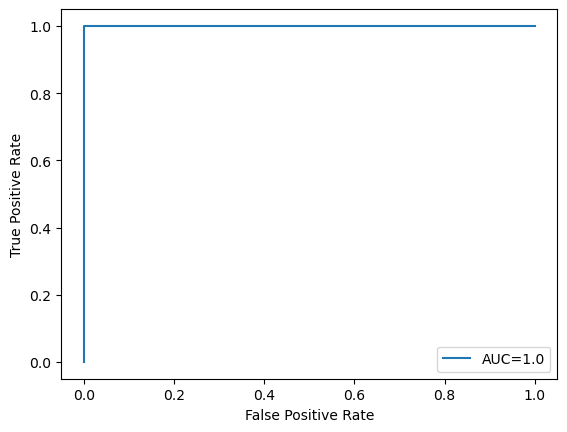

Model: f1 = 1.000 roc_auc = 1.000


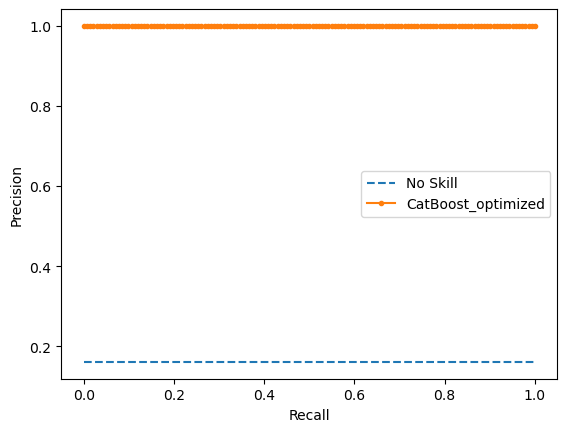


 50%|█████     | 1/2 [00:01<00:01,  1.02s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ROC/AUC: 0.6936692644389879
Accuracy: 0.8639455782312925
F1 score: 0.5121951219512195
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       493
           1       0.61      0.44      0.51        95

    accuracy                           0.86       588
   macro avg       0.75      0.69      0.72       588
weighted avg       0.85      0.86      0.85       588

[[466  27]
 [ 53  42]]


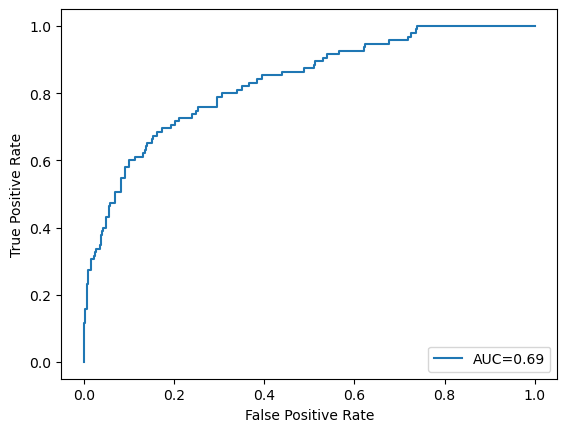

Model: f1 = 0.512 roc_auc = 0.694


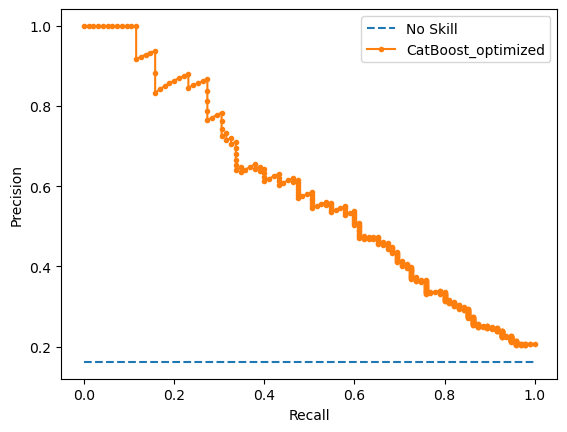


  0%|          | 0/2 [00:00<?, ?it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ROC/AUC: 0.8698705748001523
Accuracy: 0.86281179138322
F1 score: 0.6738544474393531
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       740
           1       0.55      0.88      0.67       142

    accuracy                           0.86       882
   macro avg       0.76      0.87      0.79       882
weighted avg       0.91      0.86      0.87       882

[[636 104]
 [ 17 125]]


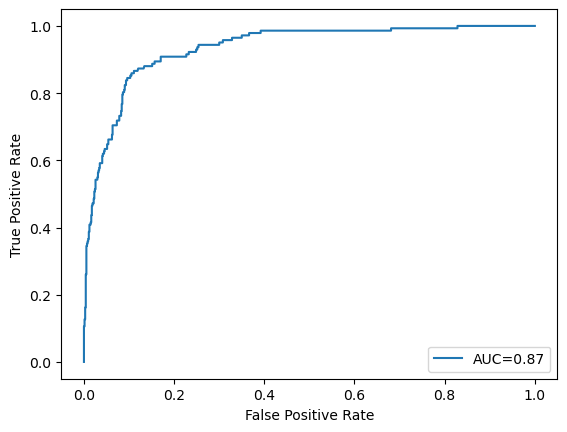

Model: f1 = 0.674 roc_auc = 0.870


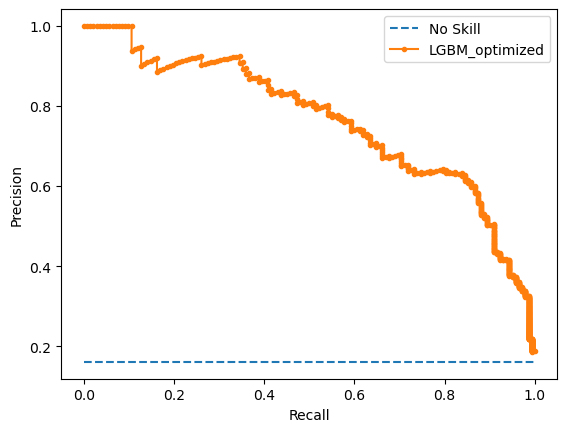


 50%|█████     | 1/2 [00:00<00:00,  1.97it/s]

ROC/AUC: 0.7218533148286538
Accuracy: 0.7687074829931972
F1 score: 0.47692307692307695


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


              precision    recall  f1-score   support

           0       0.92      0.79      0.85       493
           1       0.38      0.65      0.48        95

    accuracy                           0.77       588
   macro avg       0.65      0.72      0.66       588
weighted avg       0.83      0.77      0.79       588

[[390 103]
 [ 33  62]]


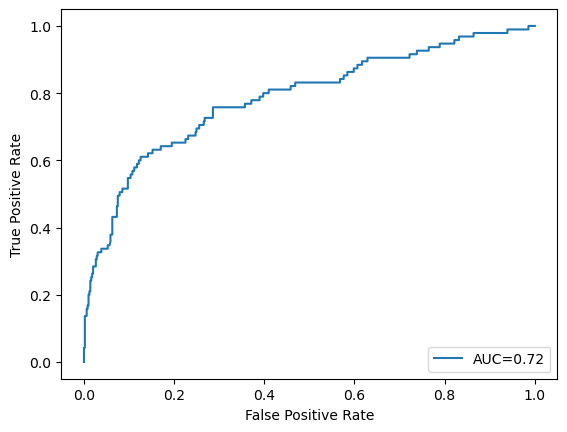

Model: f1 = 0.477 roc_auc = 0.722


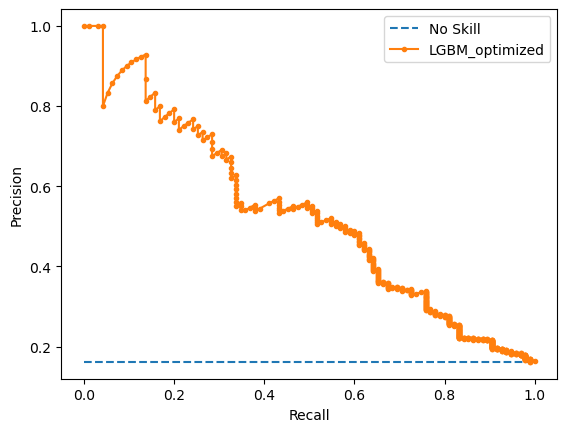


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


In [147]:
###########################################
### Assess the performance of the model ###
###########################################

models_optimized = [('CatBoost_optimized', cboost_model_hy),
                    ('LGBM_optimized', lbgm_model_hy)]

dset = [('Training', X_train_mod, y_train),
        ('Test', X_test_mod, y_test)]

results_fin = pd.DataFrame(columns = ['Model','Metrics','Training','Test'])

for name, model in tqdm(models_optimized):

    results = pd.DataFrame(['ROC/AUC:','Accuracy:','F1 score:'],
                           columns = ['Metrics'])

    for name_dset, X_dset, y_dset in tqdm(dset):

        #####################
        ### Fit the model ###
        #####################

        if name != 'LGBM_optimized':

            if name_dset == 'Training':
                model.fit(X_dset, y_dset)

            y_pred_p = model.predict_proba(X_dset)
            y_pred_p1 = y_pred_p[:,1]

        y_pred_hyp = model.predict(X_dset)
        if name == 'LGBM_optimized':
            y_pred_p1 = pd.DataFrame(y_pred_hyp)
            y_pred_hyp = np.rint(y_pred_hyp)

        metric = []
        roc_auc_hyp = roc_auc_score(y_dset, y_pred_hyp)
        metric.append(roc_auc_hyp)
        accuracy_hyp = accuracy_score(y_dset, y_pred_hyp)
        metric.append(accuracy_hyp)
        f1_score_hyp = metrics.f1_score(y_dset, y_pred_hyp)
        metric.append(f1_score_hyp)

        print('ROC/AUC:', roc_auc_hyp)
        print('Accuracy:', accuracy_hyp)
        print('F1 score:', f1_score_hyp)

        print(classification_report(y_dset, y_pred_hyp))

        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_dset, y_pred_hyp)

        cm_as_df = cm2df(cm,['Not churn','Churn'])

        print(confusion_matrix(y_dset, y_pred_hyp))

        results = pd.concat([results,
                             pd.DataFrame(metric,
                                          columns = [name_dset])],
                            axis = 1)

        #################
        ### ROC curve ###
        #################

        fpr, tpr, _ = metrics.roc_curve(y_dset,  y_pred_p1)

        plt.plot(fpr,
                 tpr,
                 label = "AUC=" + str(round(roc_auc_hyp,2)))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

        roc_data = pd.concat([pd.DataFrame(fpr),
                              pd.DataFrame(tpr)],axis = 1)
        roc_data.columns = ['FPR','TPR']
        roc_data = roc_data.reset_index()

        ###############################
        ### Precision Recall curves ###
        ###############################

        precision, recall, thresholds = precision_recall_curve(y_dset,
                                                               y_pred_p1)

        ### calculate F1 score ###

        f1 = metrics.f1_score(y_dset, y_pred_hyp)

        ### summarize scores ###

        print('Model: f1 = %.3f roc_auc = %.3f' % (f1, roc_auc_hyp))

        ### plot the precision-recall curves ###

        no_skill = len(y_dset[y_dset == 1]) / len(y_dset)

        plt.plot([0, 1],
                 [no_skill, no_skill],
                 linestyle='--',
                 label='No Skill')
        plt.plot(recall,
                 precision,
                 marker='.',
                 label = name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        ### show the legend ###
        plt.legend()
        plt.show()

        pr_data = pd.concat([pd.DataFrame(precision),
                              pd.DataFrame(recall)],axis = 1)
        pr_data.columns = ['Precision','Recall']
        pr_data = pr_data.reset_index()

        results['Model'] = name

    results_fin = pd.concat([results_fin,
                             results],
                            axis = 0)

**CatBoost model**  
  
Train 
* Accuracy = 1
* AUC = 1
  
Test 
* Accuracy = 0.86
* AUC = 0.71
  
**LGBM model**  
  
Train 
* Accuracy = 0.83
* AUC = 0.82
  
Test 
* Accuracy = 0.76 
* AUC = 0.76

In [148]:
explainer = shap.TreeExplainer(lbgm_model_hy)
shap_values = explainer.shap_values(X_train_mod)

# visualize the first prediction's explanation 
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


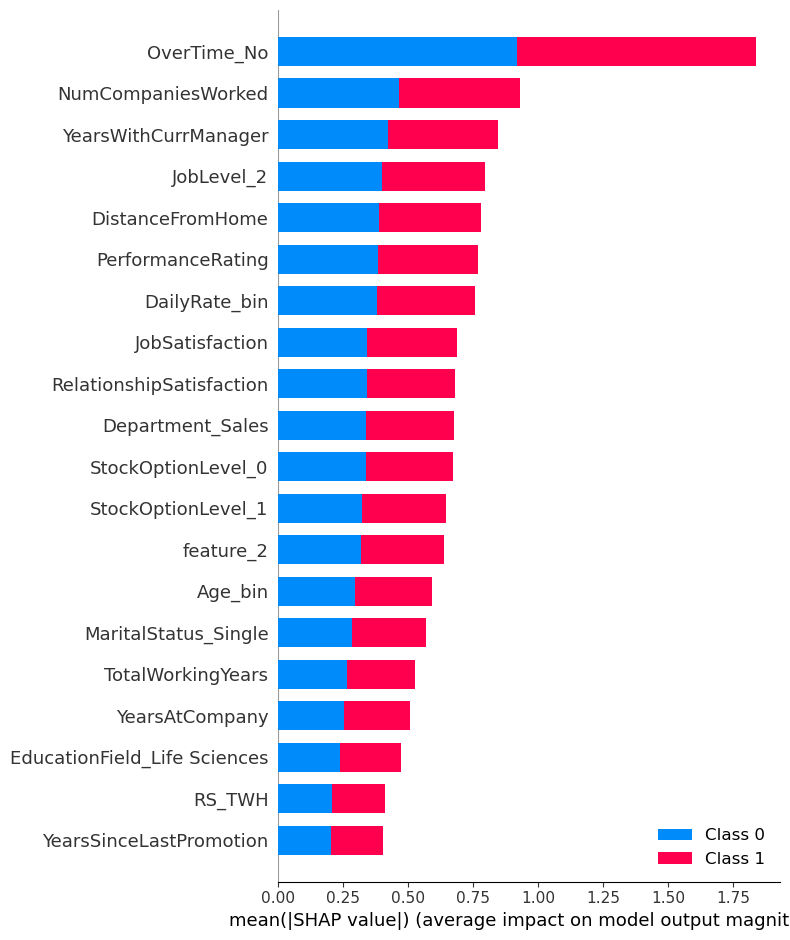

In [149]:
shap_values = shap.TreeExplainer(lbgm_model_hy).shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod, plot_type="bar");

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


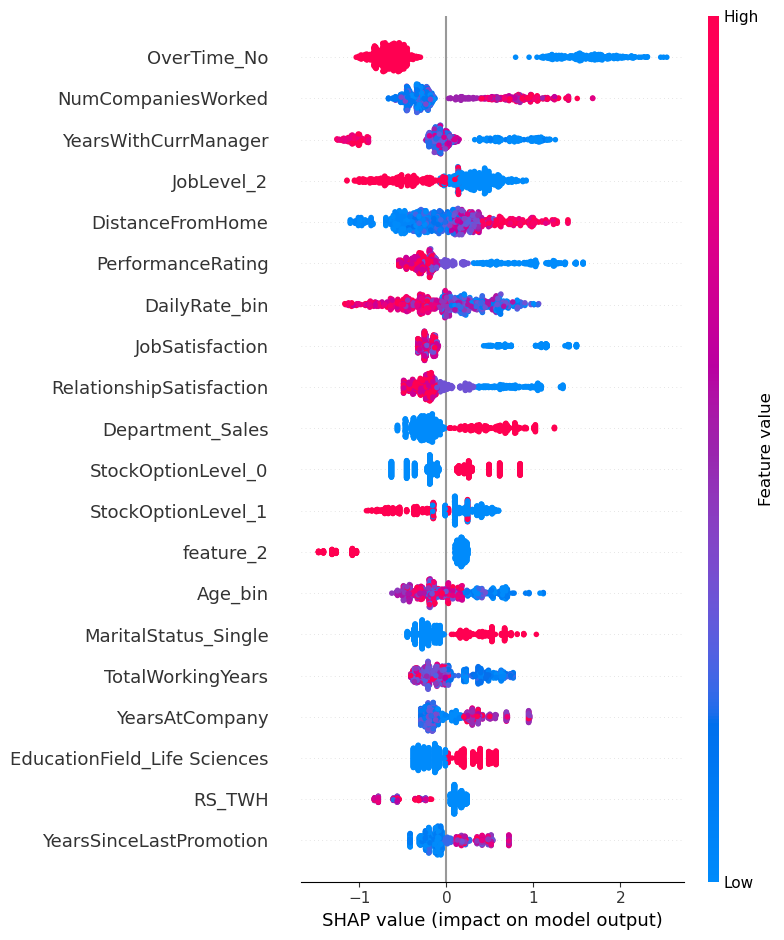

In [150]:
shap.summary_plot(shap_values[1], X_train_mod, plot_type='dot')

In [151]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Age_bin', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'DailyRate_bin', 'Department_Human_Resources', 'Department_Research__Development', 'Department_Sales', 'DistanceFromHome', 'Education', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'EnvironmentSatisfaction', 'Gender_Female', 'Gender_Male', 'HR_TWH', 'HourlyRate_bin', 'JobInvolvement', 'JobLevel_1', 'JobLevel_2', 'JobLevel_3', 'JobLevel_4', 'JobLevel_5', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'JobSatisfaction', 'LT_TWH', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MonthlyIncome_bin', 'Monthly